In [1]:
import sys
sys.path = [p for p in sys.path if "ParaView" not in p]


import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as mtri
from matplotlib.patches import Circle 
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from pydmd import DMD, HODMD, ParametricDMD
from ezyrb import POD, Database, RBF, GPR, Linear
import seaborn as sns

from pathlib import Path
import re
# For High Quality Visuals
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160  # crisp visuals


Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


# Training paramter for the partitioned parametericDMD

In [2]:
# Parameters i.e., Reynolds numbers

Re_list = [ 100, 110, 120, 130, 140, 160, 170, 180, 190, 200]  


In [3]:
print(dir(ParametricDMD))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_arrange_parametric_snapshots', '_compute_training_modal_coefficients', '_interpolate_missing_modal_coefficients', '_predict_modal_coefficients', '_reference_dmd', '_set_training_parameters', 'dmd_time', 'dmd_timesteps', 'fit', 'forecasted_modal_coefficients', 'interpolated_modal_coefficients', 'is_partitioned', 'load', 'original_time', 'original_timesteps', 'parameters', 'reconstructed_data', 'save', 'training_modal_coefficients', 'training_parameters']


In [4]:
# Base path to simulation folders
base_path = Path("~/OpenFOAM/test_1").expanduser()
Re_folders = {Re: base_path / f"cylinder_2D_Re{Re}" for Re in Re_list}

# Sampling step
sampling_step = 1

# Dictionaries to store all relevant data
snapshot_dict = {}
sampled_times_dict = {}
mask_dict = {}
num_points_dict = {}
loader_dict = {}
masked_coords_dict = {}

# Dictionaries for future-time snapshots (15.0–20.0)
snapshot_future_dict = {}
sampled_times_future_dict = {}

# Load training Reynolds numbers
for Re in Re_list:
    folder = Re_folders[Re]
    loader = FOAMDataloader(str(folder))
    times = loader.write_times

    # Training window (10.0–15.0)
    window_times = [t for t in times if 10.0 <= float(t) <= 15.0]
    sampled_times = window_times[::sampling_step]

    # Spatial mask
    vertices = loader.vertices[:, :2]
    mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])
    masked_coords = vertices[mask.numpy()]

    # Load masked snapshots
    num_points = mask.sum().item()
    num_times = len(sampled_times)
    data_matrix = pt.zeros((2 * num_points, num_times), dtype=pt.float64)
    for i, time in enumerate(sampled_times):
        snapshot = loader.load_snapshot("U", time)
        ux_masked = pt.masked_select(snapshot[:, 0], mask)
        uy_masked = pt.masked_select(snapshot[:, 1], mask)
        data_matrix[:num_points, i] = ux_masked
        data_matrix[num_points:, i] = uy_masked
    data_matrix = data_matrix.numpy()

    # Store
    snapshot_dict[Re] = data_matrix
    sampled_times_dict[Re] = sampled_times
    mask_dict[Re] = mask
    num_points_dict[Re] = num_points
    loader_dict[Re] = loader
    masked_coords_dict[Re] = masked_coords

    # Future snapshots (15.0–20.0)
    future_window_times = [t for t in times if 15.0 <= float(t) <= 20.0]
    sampled_future_times = future_window_times[::sampling_step]
    if sampled_future_times:
        num_times_future = len(sampled_future_times)
        future_data_matrix = pt.zeros((2 * num_points, num_times_future), dtype=pt.float64)
        for i, time in enumerate(sampled_future_times):
            snapshot = loader.load_snapshot("U", time)
            ux_masked = pt.masked_select(snapshot[:, 0], mask)
            uy_masked = pt.masked_select(snapshot[:, 1], mask)
            future_data_matrix[:num_points, i] = ux_masked
            future_data_matrix[num_points:, i] = uy_masked
        snapshot_future_dict[Re] = future_data_matrix.numpy()
        sampled_times_future_dict[Re] = sampled_future_times

# Load test Reynolds number 

Re_test = 150
path_test = base_path / f"cylinder_2D_Re{Re_test}"
loader_test = FOAMDataloader(str(path_test))
times_test = loader_test.write_times

# Test window (3.0–20.0)
window_times_test = [t for t in times_test if 3.0 <= float(t) <= 20.0]
sampled_times_test = window_times_test[::sampling_step]

# Spatial mask
vertices_test = loader_test.vertices[:, :2]
mask_test = mask_box(vertices_test, lower=[0.1, -1], upper=[0.75, 1])
masked_coords_test = vertices_test[mask_test.numpy()]

# Load masked snapshots
num_points_test = mask_test.sum().item()
num_times_test = len(sampled_times_test)
data_matrix_test = pt.zeros((2 * num_points_test, num_times_test), dtype=pt.float64)
for i, time in enumerate(sampled_times_test):
    snapshot = loader_test.load_snapshot("U", time)
    ux_masked = pt.masked_select(snapshot[:, 0], mask_test)
    uy_masked = pt.masked_select(snapshot[:, 1], mask_test)
    data_matrix_test[:num_points_test, i] = ux_masked
    data_matrix_test[num_points_test:, i] = uy_masked
snapshot_test = data_matrix_test.numpy()

# Store in same dictionaries
snapshot_dict[Re_test] = snapshot_test
sampled_times_dict[Re_test] = sampled_times_test
mask_dict[Re_test] = mask_test
num_points_dict[Re_test] = num_points_test
loader_dict[Re_test] = loader_test
masked_coords_dict[Re_test] = masked_coords_test

print("Data loaded for Reynolds numbers:", Re_list, "and test Re =", Re_test)


INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading pr

Data loaded for Reynolds numbers: [100, 110, 120, 130, 140, 160, 170, 180, 190, 200] and test Re = 150


In [5]:
# Print the loaded data matrix shape for each Parameter i.e., Reynolds number

for Re in Re_list:
    print(f"Re={Re}, shape={snapshot_dict[Re].shape}")


Re=100, shape=(11492, 501)
Re=110, shape=(11492, 501)
Re=120, shape=(11492, 501)
Re=130, shape=(11492, 501)
Re=140, shape=(11492, 501)
Re=160, shape=(11492, 501)
Re=170, shape=(11492, 501)
Re=180, shape=(11492, 501)
Re=190, shape=(11492, 501)
Re=200, shape=(11492, 501)


## Subtract mean flow and normalize the snapshots

In [6]:
# Stack all training snapshots across Re and time (10.0–15.0)
all_training_snapshots = np.concatenate([
    snapshot_dict[Re].T for Re in Re_list
], axis=0)  # shape: (n_total_snapshots, space_dim)

# Compute mean flow from training snapshots only
mean_flow = np.mean(all_training_snapshots, axis=0)  # shape: (space_dim,)
print("Mean flow computed from training window Shape:", mean_flow.shape)

# Subtract mean and normalize each snapshot block (training Re)
snapshot_processed_dict = {}
norm_scales = {}

for Re in Re_list:
    snapshots = snapshot_dict[Re].copy()
    snapshots -= mean_flow[:, np.newaxis]
    norm = np.linalg.norm(snapshots)
    snapshots /= norm
    snapshot_processed_dict[Re] = snapshots
    norm_scales[Re] = norm

print("Mean flow subtracted and snapshots normalized for each training snapshot matrix.")

# Stack normalized training snapshots into shape: (n_Re, space_dim, n_time)
train_snapshots = np.array([
    snapshot_processed_dict[Re] for Re in Re_list
])
print("train_snapshots shape:", train_snapshots.shape)

# Process Re_test separately for visualization
snapshot_processed_test = snapshot_dict[Re_test].copy()
snapshot_processed_test -= mean_flow[:, np.newaxis]   
norm_test = np.linalg.norm(snapshot_processed_test)
snapshot_processed_test /= norm_test


snapshot_processed_dict[Re_test] = snapshot_processed_test
norm_scales[Re_test] = norm_test

print(f"Test Re={Re_test}: processed shape = {snapshot_processed_test.shape}, norm scale = {norm_test:.4f}")


Mean flow computed from training window Shape: (11492,)
Mean flow subtracted and snapshots normalized for each training snapshot matrix.
train_snapshots shape: (10, 11492, 501)
Test Re=150: processed shape = (11492, 1701), norm scale = 1147.8000


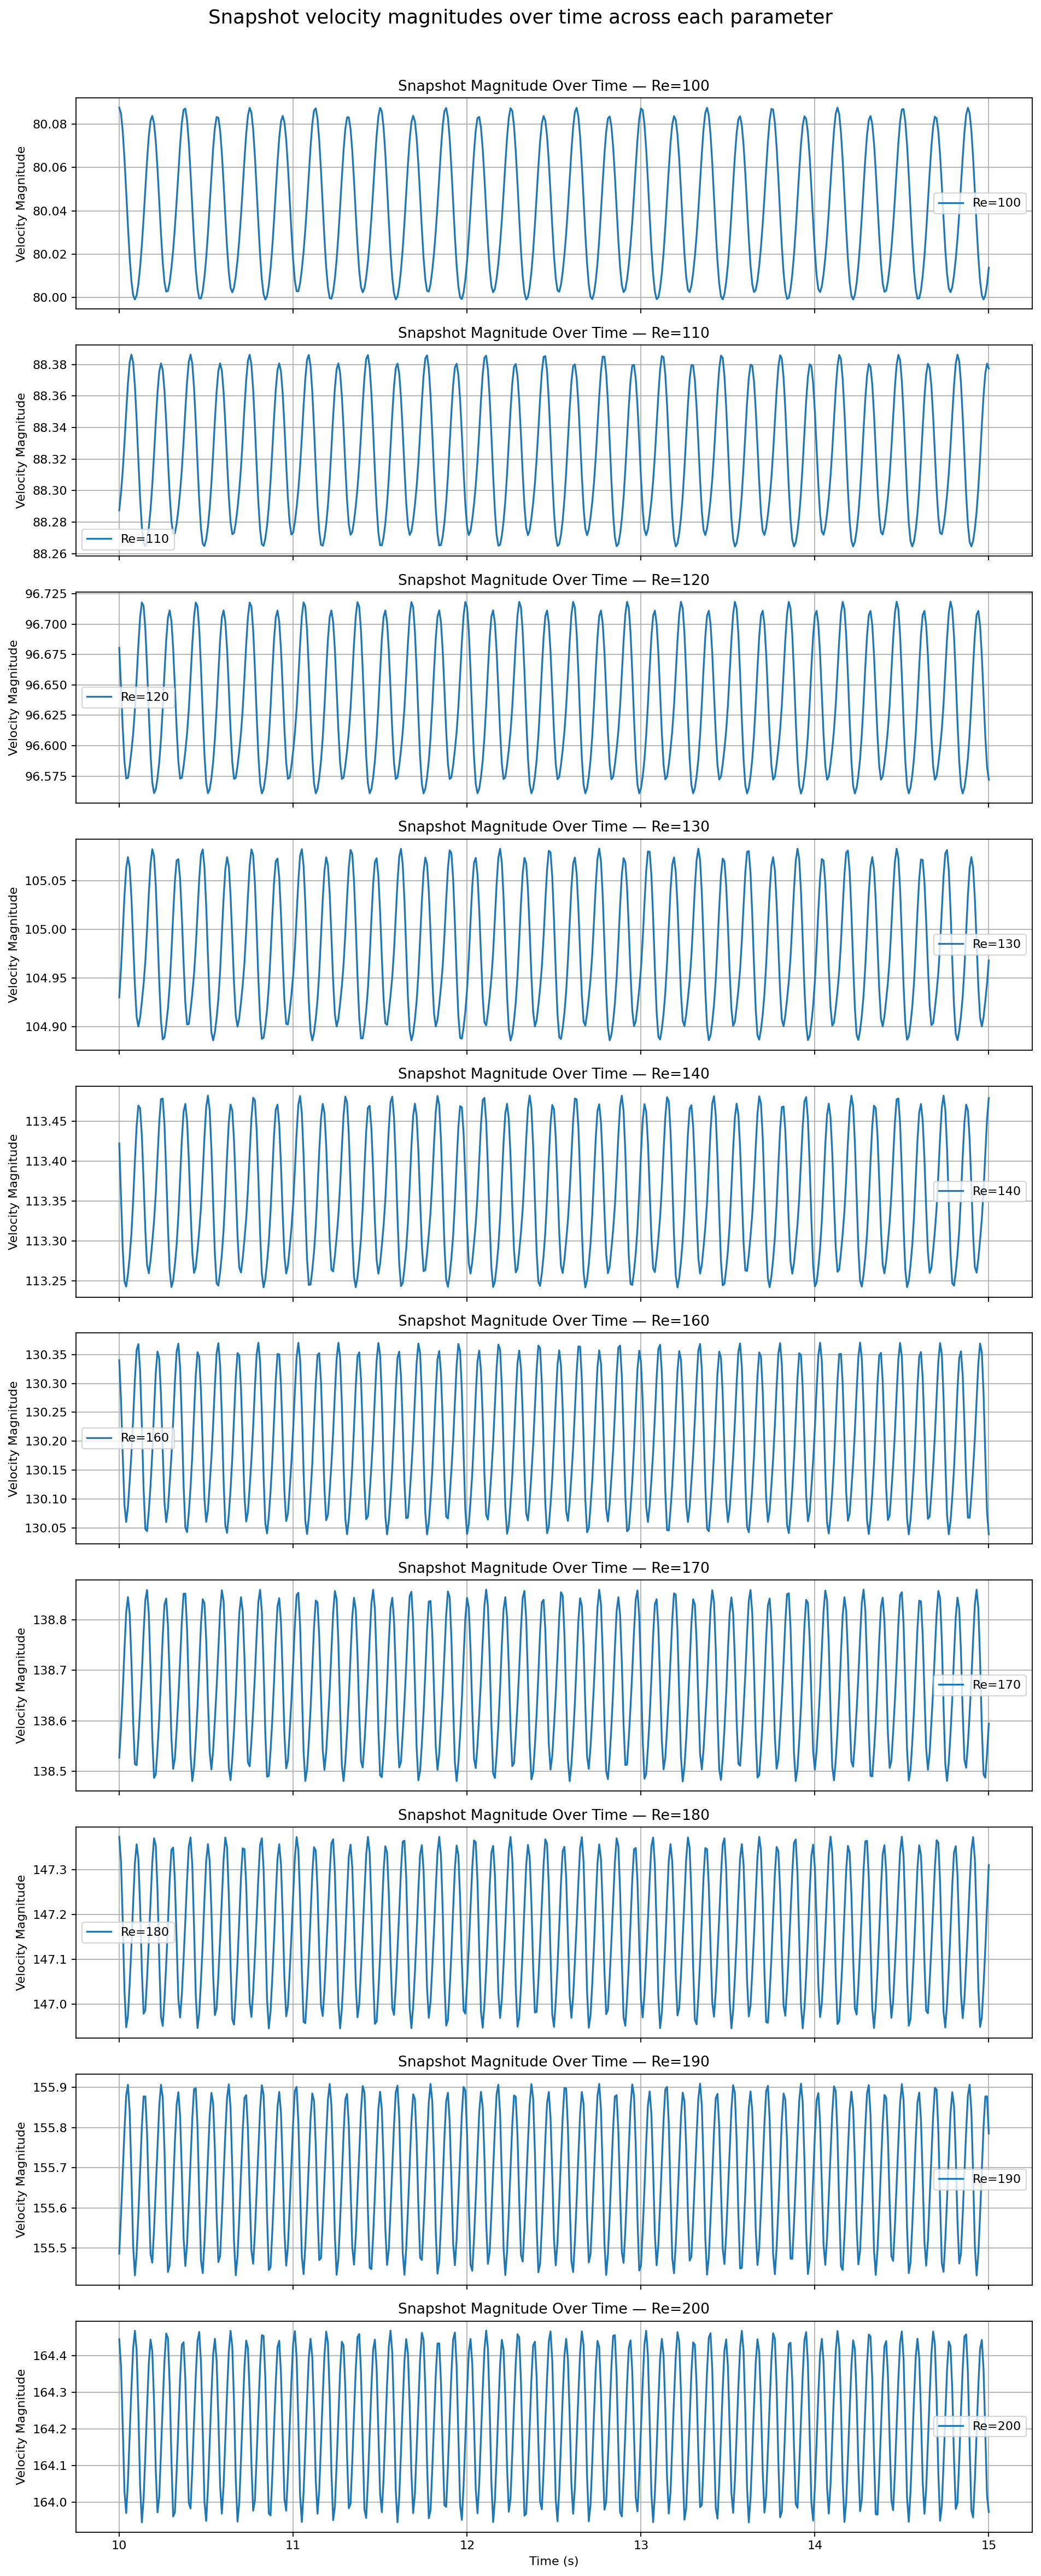

In [7]:
# Snapshot magnitude over time for each Parameter i.e., Reynolds number

n_re = len(Re_list)
fig, axes = plt.subplots(n_re, 1, figsize=(12, 3 * n_re), sharex=True)

for i, Re in enumerate(Re_list):
    # Global snapshot magnitudes (L2 norm over space at each sampled time)
    mags = np.linalg.norm(snapshot_dict[Re], axis=0)

    # Plot
    times = np.array(sampled_times_dict[Re], dtype=float)
    ax = axes[i]
    ax.plot(times, mags, label=f"Re={Re}", color='tab:blue')
    ax.set_ylabel("Velocity Magnitude")
    ax.set_title(f"Snapshot Magnitude Over Time — Re={Re}")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Time (s)")
plt.suptitle("Snapshot velocity magnitudes over time across each parameter", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])

## Offline Phase

## Step 1: Perform POD and DMD on the concatenated snapshot matrix X1

In [8]:
# Parametric DMD with varying POD ranks


svd_ranks_to_test = [5, 10, 20, 30, 40, 50]  
pdmd_models_by_rank = {}
pdmd_results_by_rank = {}

for rank in svd_ranks_to_test:
    print(f"\nTesting POD rank = {rank}")

    # Step 1: DMD instances always full rank (-1)
    trained_dmds = [DMD(svd_rank=-1) for _ in Re_list]

    # Step 2: Shared POD basis with variable rank
    rom = POD(rank=rank, method="randomized_svd")

    # Step 3: Interpolator
    interpolator = RBF()

    # Step 4: Construct and fit ParametricDMD
    pdmd = ParametricDMD(trained_dmds, rom, interpolator, light=False)
    pdmd.fit(train_snapshots, np.array(Re_list).reshape(-1, 1))

    # Step 5: Store model
    pdmd_models_by_rank[rank] = pdmd

    # Step 6: Store immediate results (no interpolated yet)
    pdmd_results_by_rank[rank] = {
        "training_parameters": pdmd.training_parameters.copy(),
        "training_modal_coefficients": pdmd.training_modal_coefficients.copy(),
        "dmd_time": pdmd.dmd_time.copy(),
        "original_time": pdmd.original_time.copy(),
        "parameters": pdmd.parameters.copy() if pdmd.parameters is not None else None
    }



Testing POD rank = 5


INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)
INFO:root:Snapshots: (5, 501), snapshot shape: (5,)



Testing POD rank = 10


INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)
INFO:root:Snapshots: (10, 501), snapshot shape: (10,)



Testing POD rank = 20


/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1095705.3050971678. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (20, 501), snapshot shape: (20,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 771300.5546082777. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (20, 501), snapshot shape: (20,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 193639.60348714425. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (20, 501), snapshot shape: (20,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snap


Testing POD rank = 30


/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1800785.9409092155. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (30, 501), snapshot shape: (30,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1089558.6560719926. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (30, 501), snapshot shape: (30,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 439806.7794769989. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (30, 501), snapshot shape: (30,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snap


Testing POD rank = 40


/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 3403225.34575033. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (40, 501), snapshot shape: (40,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1536735.0240926922. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (40, 501), snapshot shape: (40,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 810715.4381273364. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (40, 501), snapshot shape: (40,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapsh


Testing POD rank = 50


/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 4272632.98562013. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (50, 501), snapshot shape: (50,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2382307.0047077425. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (50, 501), snapshot shape: (50,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1069472.7656739135. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
INFO:root:Snapshots: (50, 501), snapshot shape: (50,)
/home/haseeb/ml-cfd-lecture/ml-cfd/lib/python3.12/site-packages/pydmd/snaps

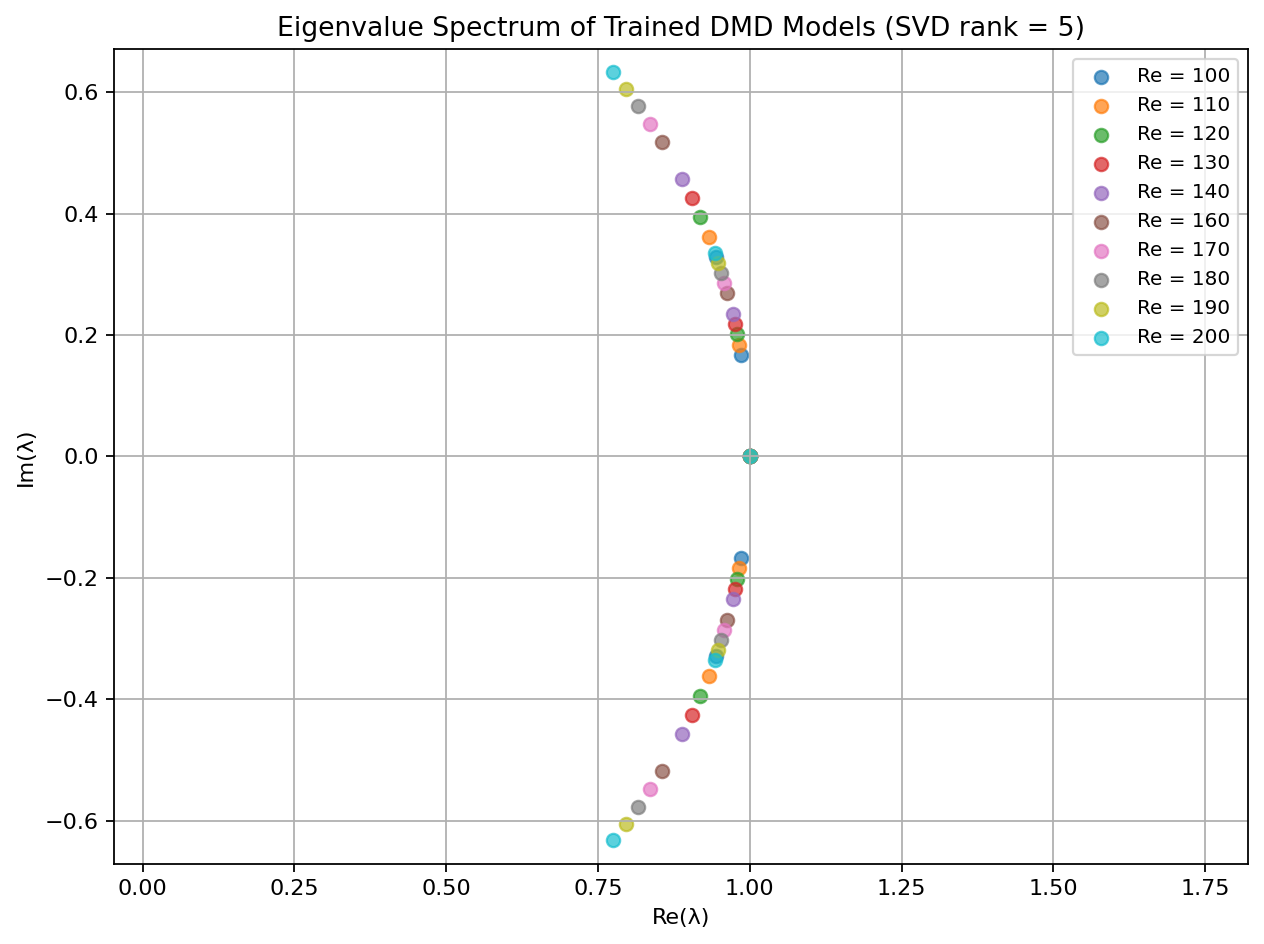

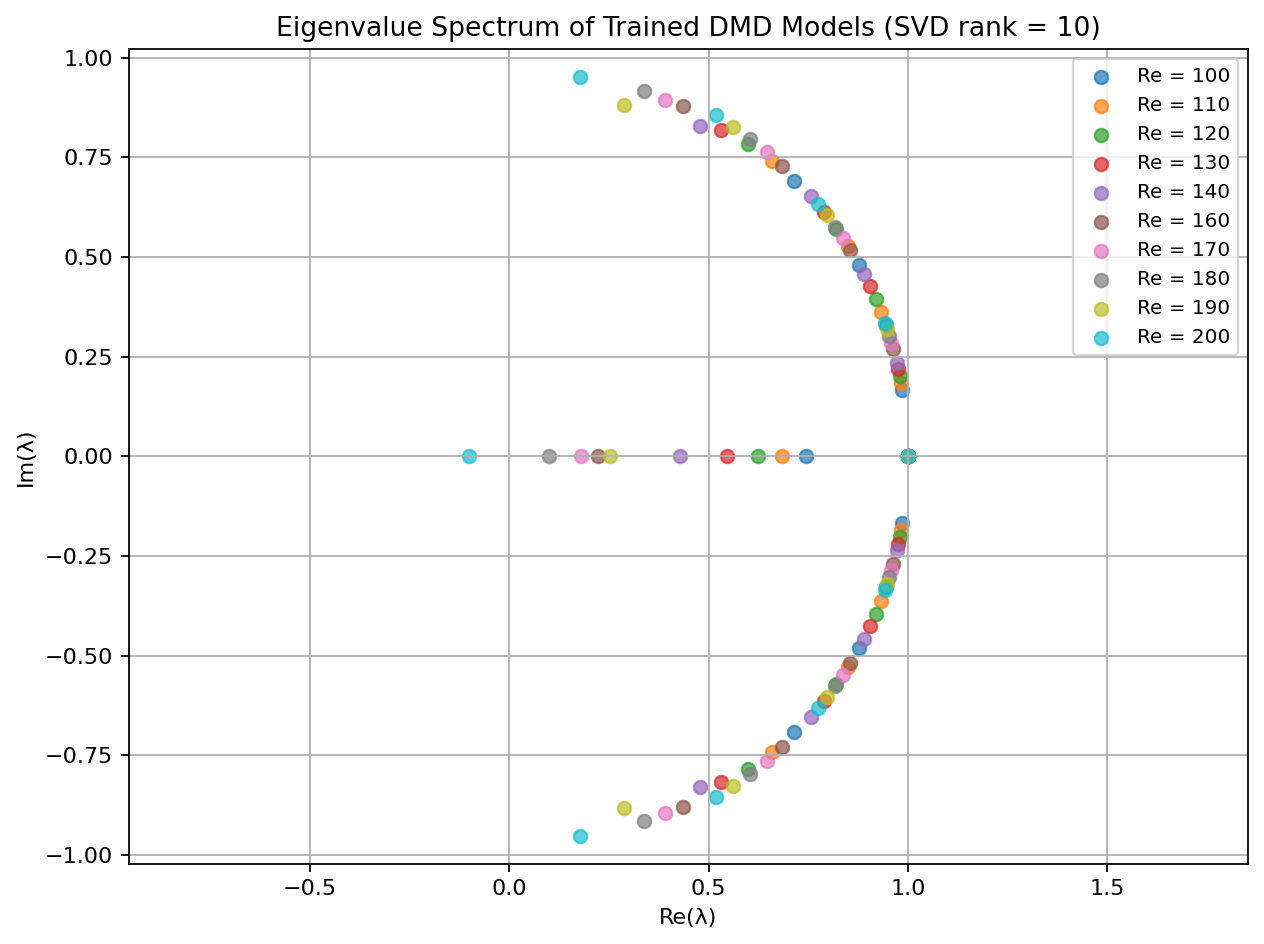

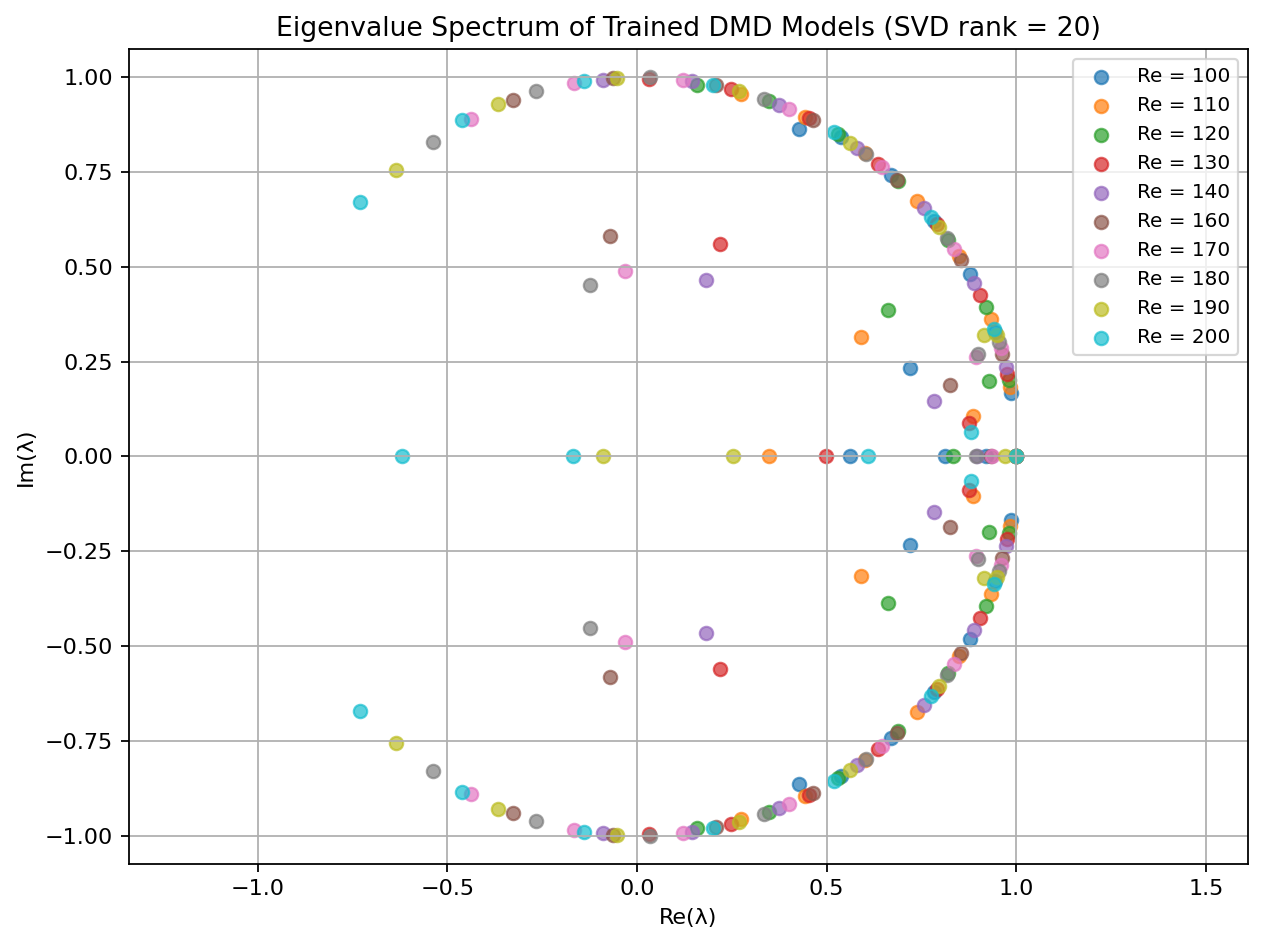

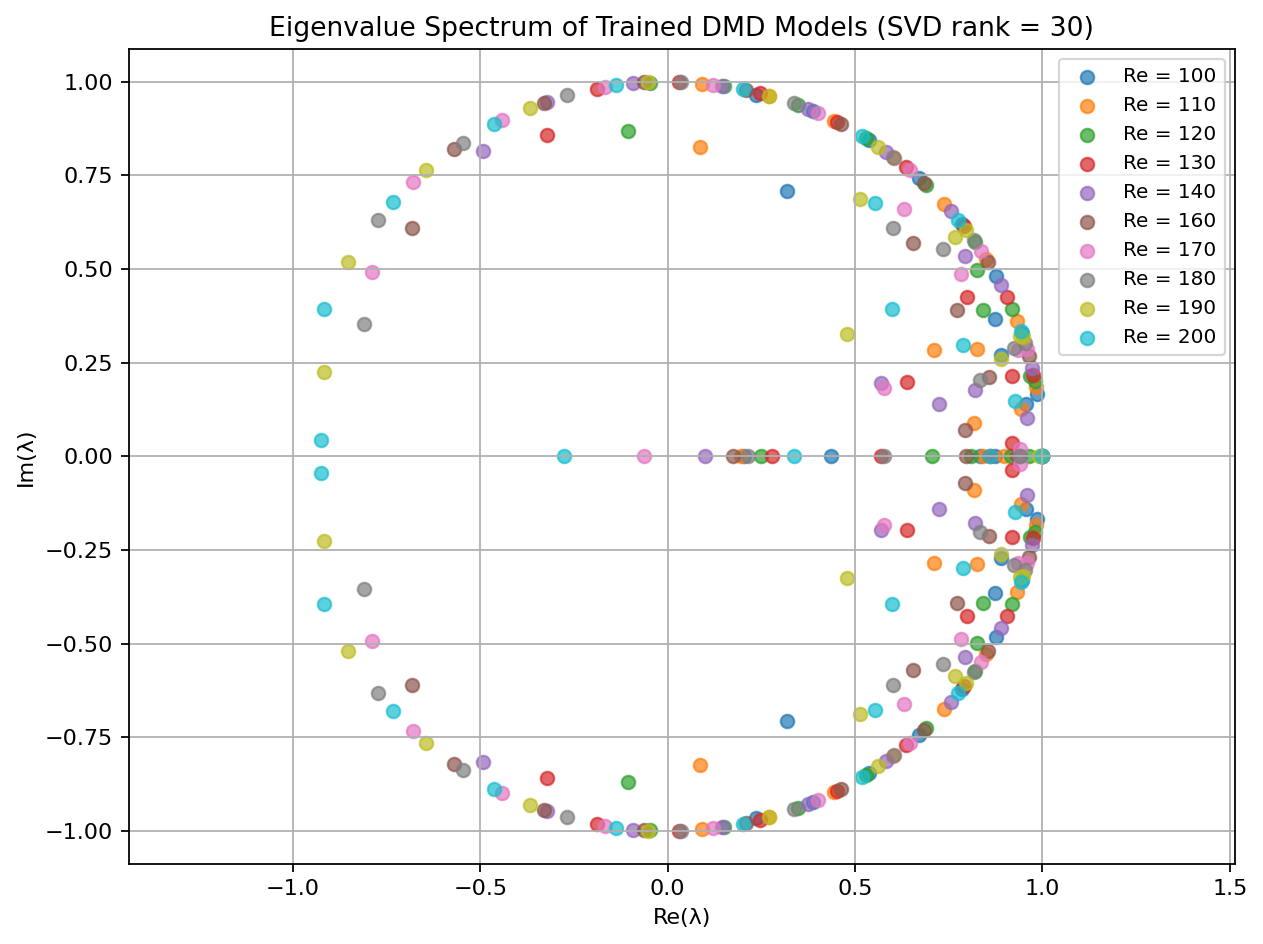

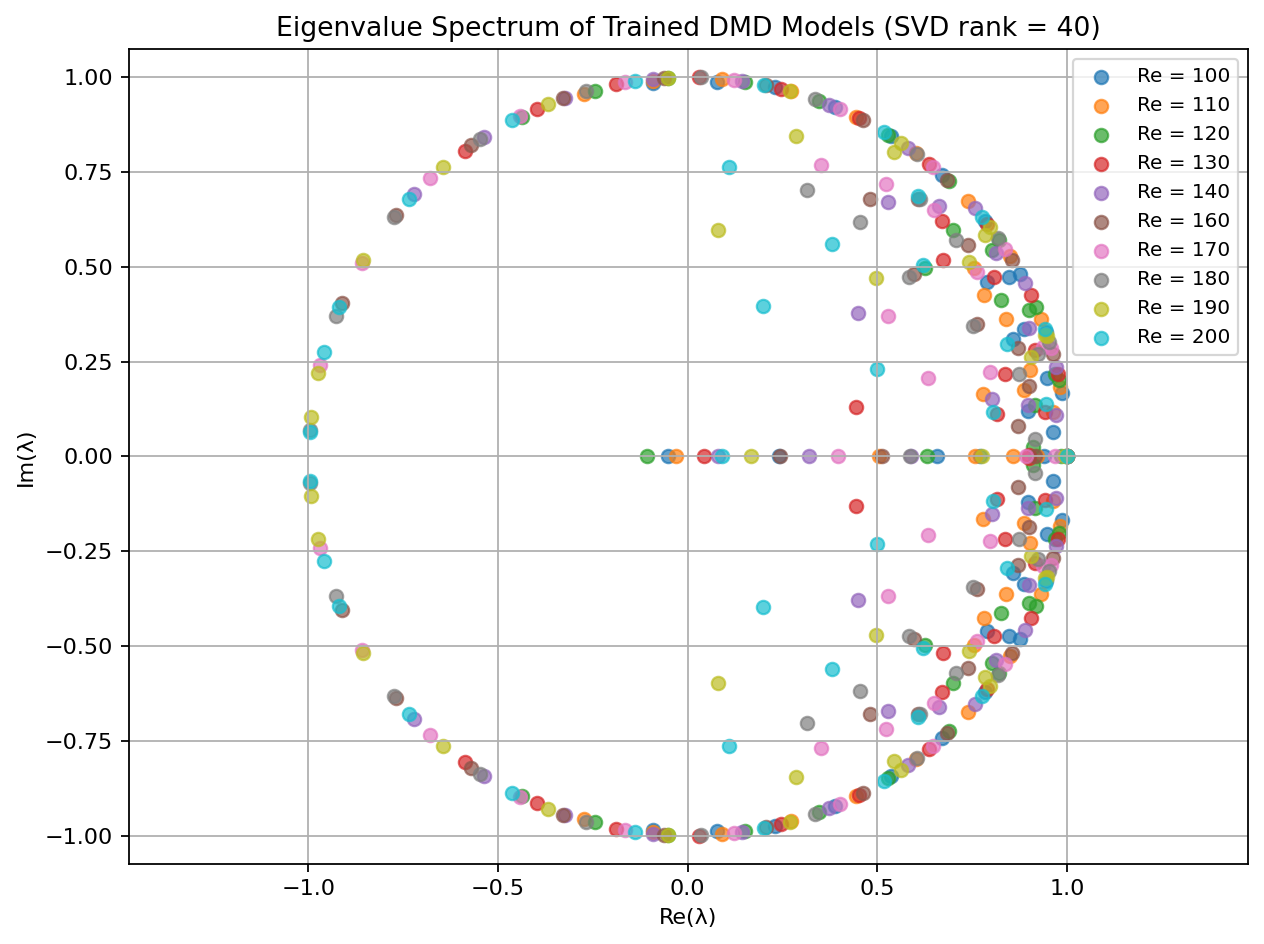

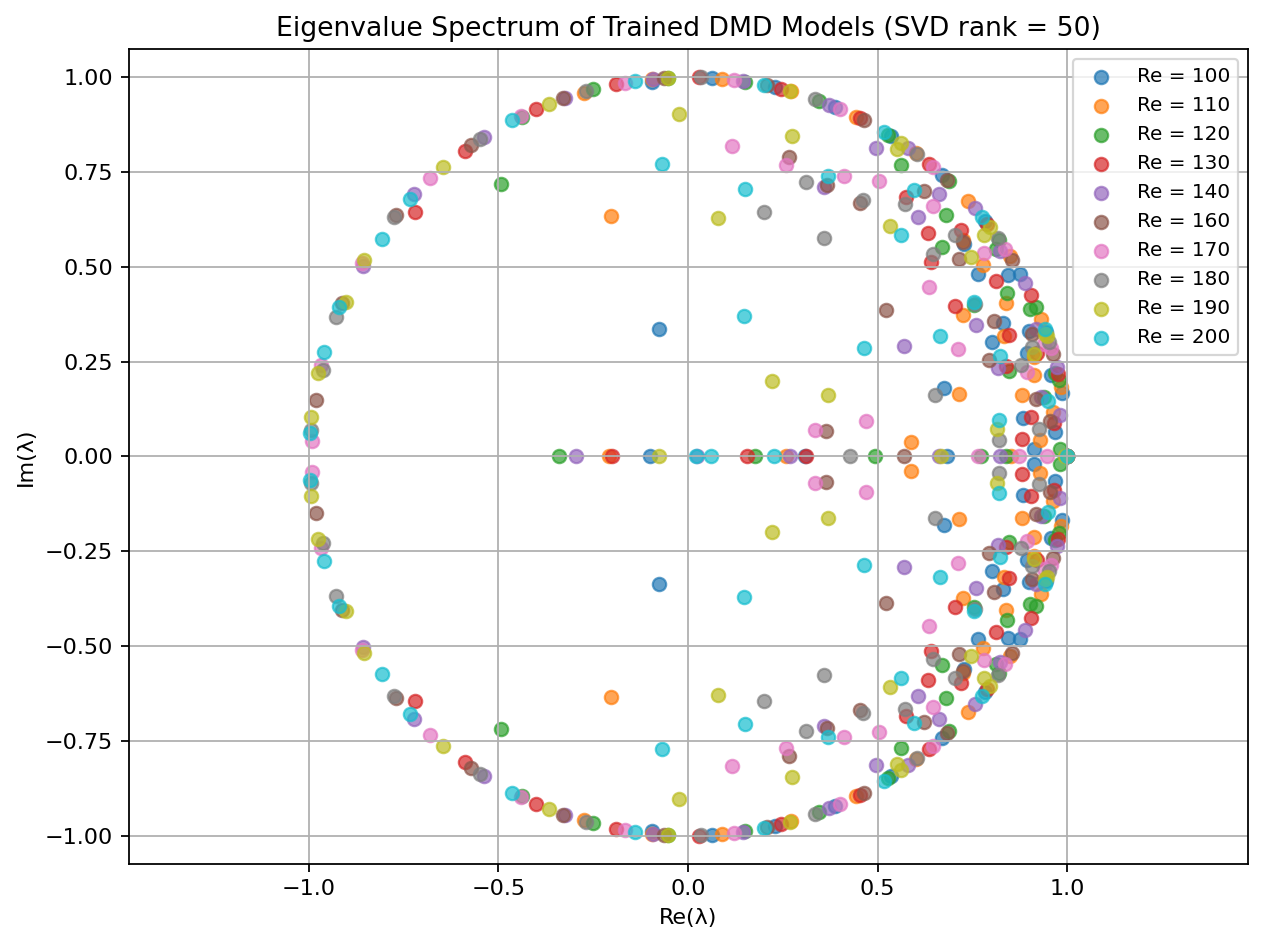

In [9]:
# Loop over all POD ranks and plot eigenvalue spectra
for rank, pdmd in pdmd_models_by_rank.items():
    plt.figure(figsize=(8, 6))

    for i, dmd in enumerate(pdmd._dmd):
        eigs = dmd.eigs
        Re = Re_list[i]
        plt.scatter(np.real(eigs), np.imag(eigs), label=f"Re = {Re}", alpha=0.7)

    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title(f"Eigenvalue Spectrum of Trained DMD Models (SVD rank = {rank})")
    plt.grid(True)
    plt.axis("equal")
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()


# SVD rank error analysis plots

#### ParametericDMD reconstruction error for the trained parameters within the training window.

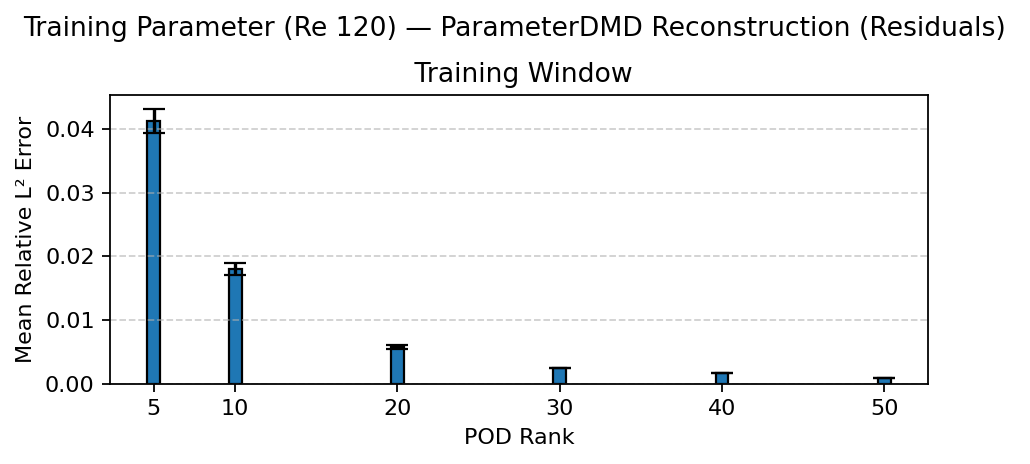

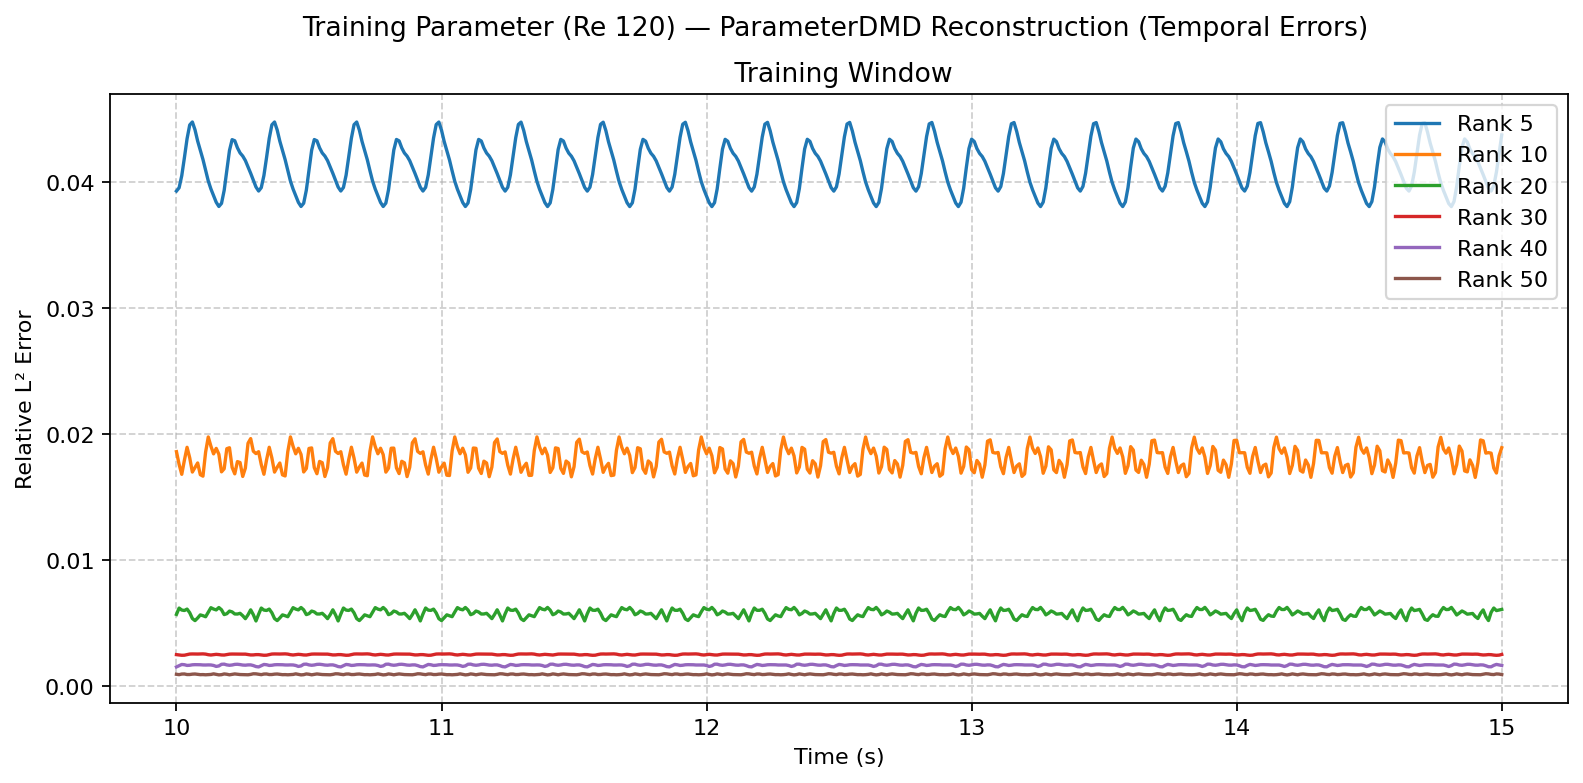

In [10]:
# Plot ParametericDMD reconstruction errors on training window in physical space

Re_train = 120
error_curves_train_window = {}

# Compute reconstruction error for each POD rank using physical-space snapshots
for rank, pdmd in pdmd_models_by_rank.items():
    true_train_window = snapshot_processed_dict[Re_train] * norm_scales[Re_train] + mean_flow[:, None]
    recon_train_window = pdmd._spatial_pod.expand(
        pdmd.training_modal_coefficients[Re_list.index(Re_train)]
    )
    recon_train_window = recon_train_window[:, :true_train_window.shape[1]]
    recon_train_window = recon_train_window * norm_scales[Re_train] + mean_flow[:, None]
    err_train_window = np.linalg.norm(true_train_window - recon_train_window, axis=0) / np.linalg.norm(true_train_window, axis=0)
    error_curves_train_window[rank] = err_train_window

# Bar plot: mean ± std of relative L² error per rank
mean_err = [np.mean(v) for v in error_curves_train_window.values()]
std_err  = [np.std(v) for v in error_curves_train_window.values()]
sorted_ranks = sorted(error_curves_train_window.keys())

plt.figure(figsize=(6,3))
plt.bar(error_curves_train_window.keys(), mean_err, yerr=std_err, capsize=5, edgecolor='black')
plt.xticks(sorted_ranks)
plt.title(f"Training Parameter (Re {Re_train}) — ParameterDMD Reconstruction (Residuals) \n Training Window", linespacing=2)
plt.xlabel("POD Rank")
plt.ylabel("Mean Relative L² Error")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Curve plot: error vs physical time
time_vec_train = np.array(sampled_times_dict[Re_train], dtype=float)

plt.figure(figsize=(10,5))
for rank, curve in error_curves_train_window.items():
    plt.plot(time_vec_train, curve, label=f"Rank {rank}")
plt.title(f"Training Parameter (Re {Re_train}) — ParameterDMD Reconstruction (Temporal Errors) \n Training Window", linespacing=2)
plt.xlabel("Time (s)")
plt.ylabel("Relative L² Error")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Online Phase

## Forecasting and interpolation for unkonwn Reynolds number

In [11]:
# Forecast for the trained parameters and interpolate for untrained parameters

Re_interp = 150  
forecast_window = 500  
forecasted_fields_by_rank = {}

for rank, pdmd in pdmd_models_by_rank.items():
    print(f"\nForecasting for POD rank = {rank}")

    # Step 1: Define forecasting time range
    training_times = np.array(sampled_times_dict[Re_list[0]], dtype=float)
    pdmd.dmd_time["t0"]   = pdmd.original_time["tend"]
    pdmd.dmd_time["tend"] = pdmd.original_time["tend"] + forecast_window - 1e-12
    pdmd.dmd_time["dt"]   = pdmd.original_time["dt"]

    # Step 2: Set target Re for interpolation
    pdmd.parameters = np.array([[Re_interp]])

    # Step 3: Trigger reconstruction
    forecasted_snapshots = pdmd.reconstructed_data  # shape: (1, space_dim, time_steps)
    forecasted_field = forecasted_snapshots[0]      # shape: (space_dim, time_steps)

    # Step 4: Print time vector
    print(f"Forecasting from t = {pdmd.dmd_time['t0']} to t = {pdmd.dmd_time['tend']} with Δt = {pdmd.dmd_time['dt']}")
    

    # Step 5: Store forecasted field
    forecasted_fields_by_rank[rank] = forecasted_field
print("Time vector:", pdmd.dmd_timesteps)



Forecasting for POD rank = 5
Forecasting from t = 500 to t = 999.999999999999 with Δt = 1

Forecasting for POD rank = 10
Forecasting from t = 500 to t = 999.999999999999 with Δt = 1

Forecasting for POD rank = 20
Forecasting from t = 500 to t = 999.999999999999 with Δt = 1

Forecasting for POD rank = 30
Forecasting from t = 500 to t = 999.999999999999 with Δt = 1

Forecasting for POD rank = 40
Forecasting from t = 500 to t = 999.999999999999 with Δt = 1

Forecasting for POD rank = 50
Forecasting from t = 500 to t = 999.999999999999 with Δt = 1
Time vector: [ 500.  501.  502.  503.  504.  505.  506.  507.  508.  509.  510.  511.
  512.  513.  514.  515.  516.  517.  518.  519.  520.  521.  522.  523.
  524.  525.  526.  527.  528.  529.  530.  531.  532.  533.  534.  535.
  536.  537.  538.  539.  540.  541.  542.  543.  544.  545.  546.  547.
  548.  549.  550.  551.  552.  553.  554.  555.  556.  557.  558.  559.
  560.  561.  562.  563.  564.  565.  566.  567.  568.  569.  570.  571

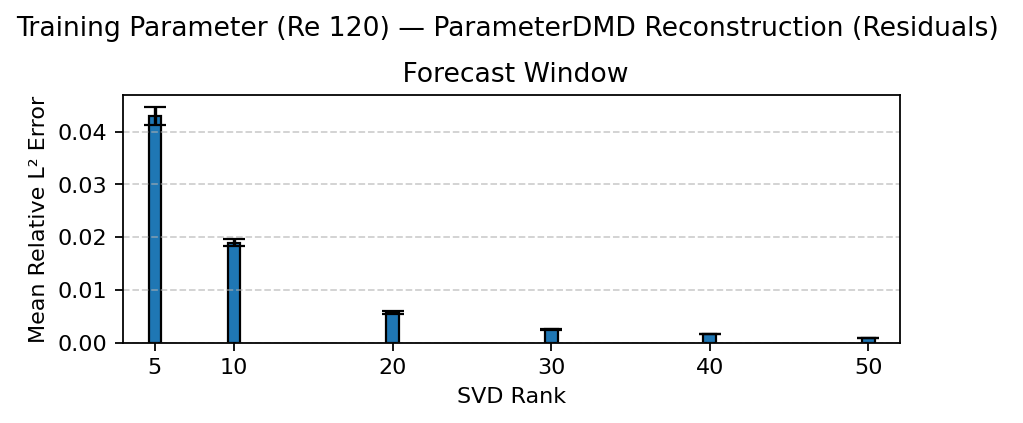

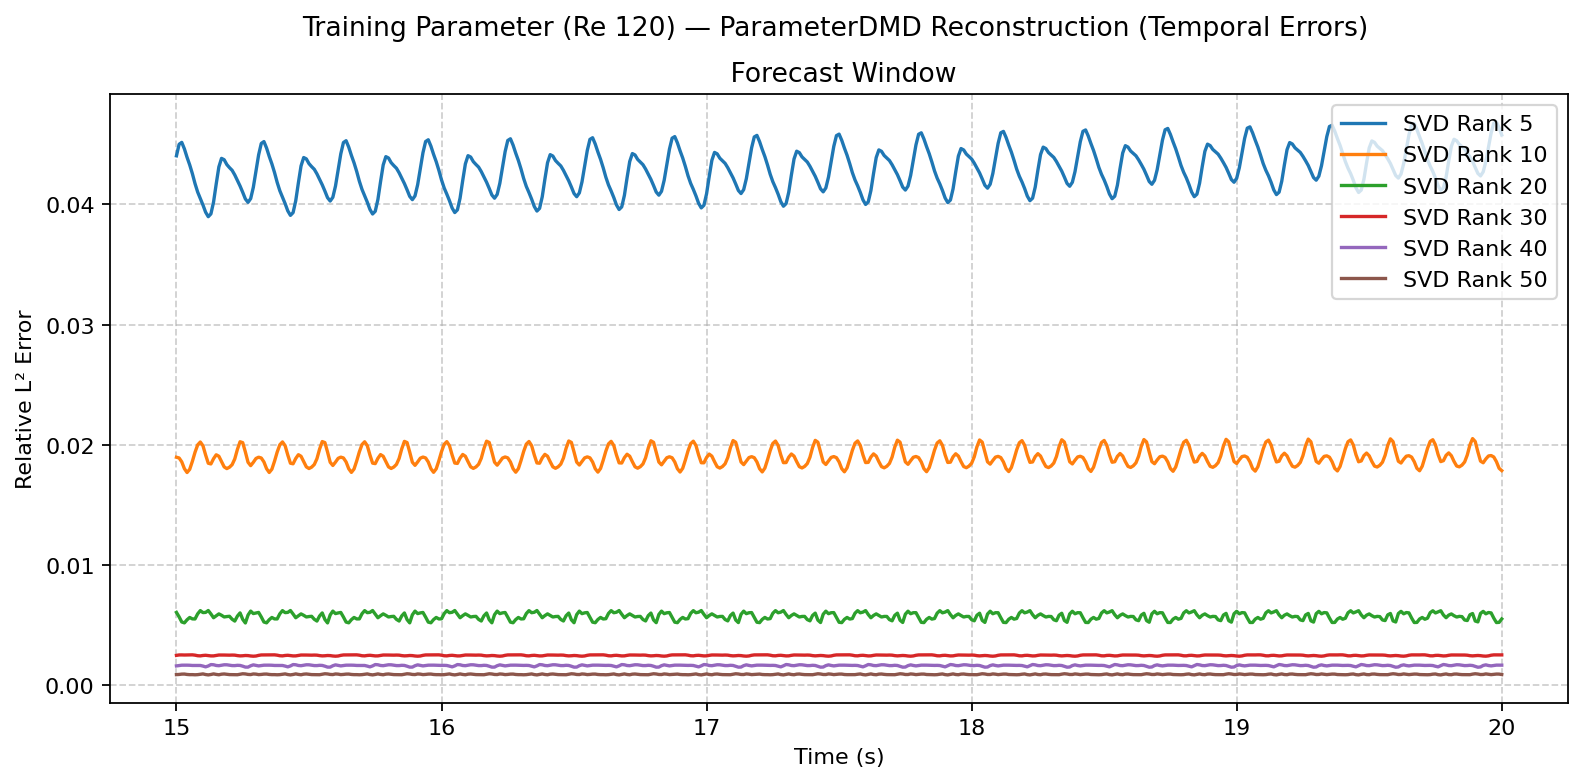

In [14]:
# Plot ParametericDMD forecast errors on training Re in forecast window 

Re_train = 120
error_curves_train_forecast = {}

# Compute forecast error for each POD rank on training Re in forecast window
for rank, pdmd in pdmd_models_by_rank.items():
    true_train_forecast = snapshot_future_dict[Re_train]
    pdmd.parameters = np.array([[Re_train]])
    forecast_train = pdmd.reconstructed_data[0]
    forecast_train = forecast_train[:, :true_train_forecast.shape[1]]
    forecast_train = forecast_train * norm_scales[Re_train] + mean_flow[:, None]
    err_train_forecast = np.linalg.norm(true_train_forecast - forecast_train, axis=0) / np.linalg.norm(true_train_forecast, axis=0)
    error_curves_train_forecast[rank] = err_train_forecast

# Bar plot: mean ± std of relative L² error per rank
sorted_ranks = sorted(error_curves_train_forecast.keys())
mean_err = [np.mean(error_curves_train_forecast[r]) for r in sorted_ranks]
std_err  = [np.std(error_curves_train_forecast[r]) for r in sorted_ranks]

plt.figure(figsize=(6,3))
plt.bar(sorted_ranks, mean_err, yerr=std_err, capsize=5, edgecolor='black')
plt.xticks(sorted_ranks, [str(r) for r in sorted_ranks])  # force string labels
plt.xlim(min(sorted_ranks) - 2, max(sorted_ranks) + 2)     # force axis to include all ranks
plt.title(f"Training Parameter (Re {Re_train}) — ParameterDMD Reconstruction (Residuals) \n Forecast Window", linespacing=2)
plt.xlabel("SVD Rank")
plt.ylabel("Mean Relative L² Error")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(pad=2.0)
plt.show()

# Curve plot: error vs physical time
time_vec_forecast = np.array(sampled_times_future_dict[Re_train], dtype=float)

plt.figure(figsize=(10,5))
for r in sorted_ranks:
    plt.plot(time_vec_forecast, error_curves_train_forecast[r], label=f"SVD Rank {r}")
plt.title(f"Training Parameter (Re {Re_train}) — ParameterDMD Reconstruction (Temporal Errors) \n Forecast Window", linespacing=2)
plt.xlabel("Time (s)")
plt.ylabel("Relative L² Error")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


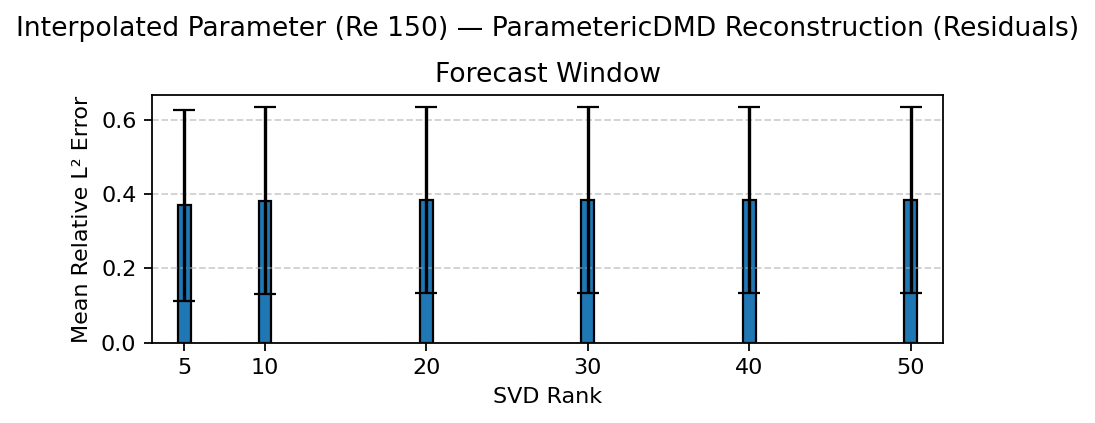

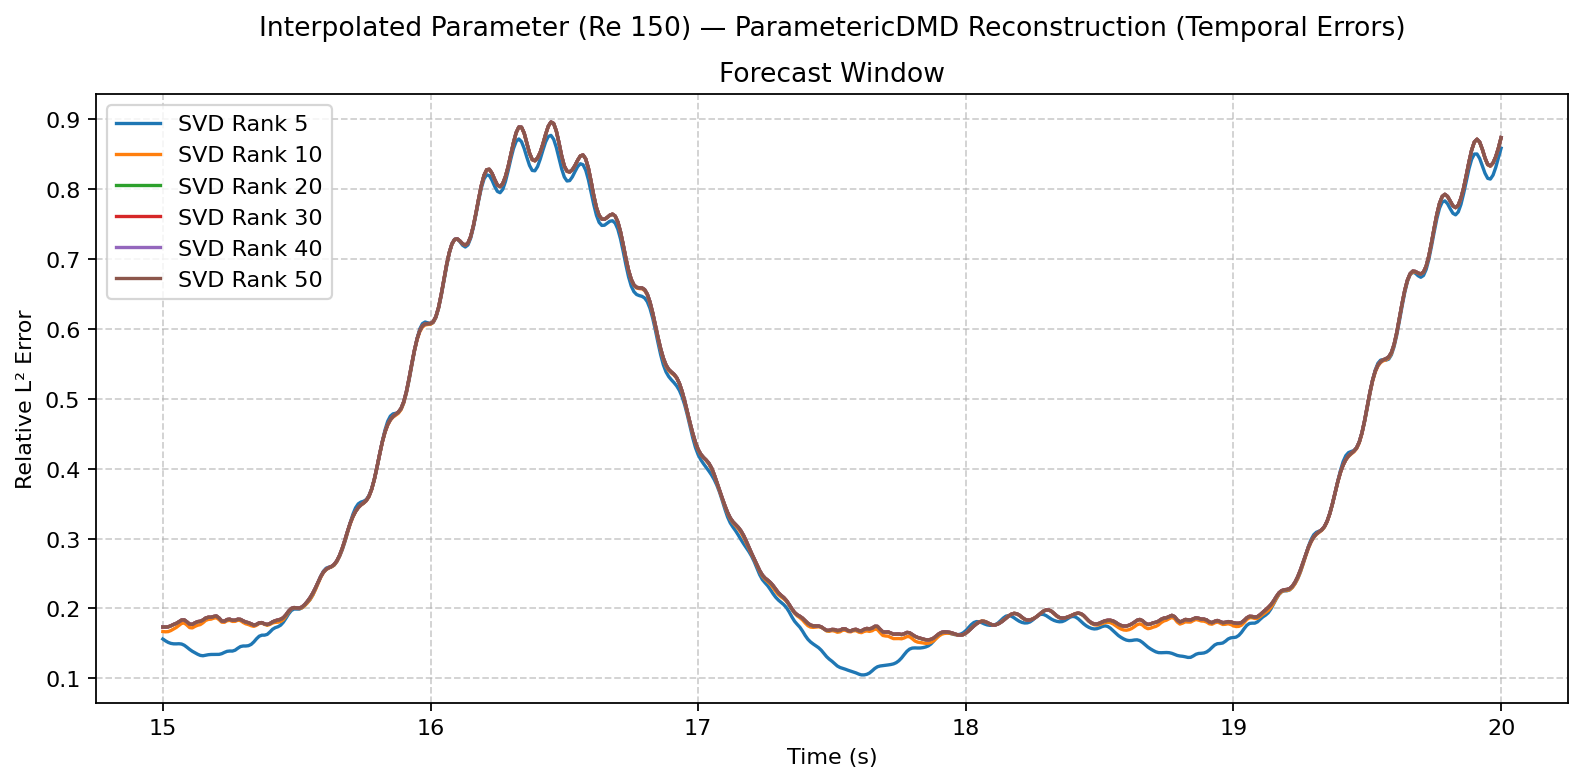

In [15]:
# Plot ParametericDMD forecast errors on interpolated Re in forecast window 

Re_interp = 150
error_curves_interp_forecast = {}

# Extract sampled forecast window (15.0–20.0) from snapshot_dict
sampled_times = np.array(sampled_times_dict[Re_interp], dtype=float)
forecast_mask = (sampled_times >= 15.0) & (sampled_times <= 20.0)
true_interp_forecast = snapshot_dict[Re_interp][:, forecast_mask]
time_vec_interp = sampled_times[forecast_mask]
num_snapshots = true_interp_forecast.shape[1]

for rank in pdmd_models_by_rank:
    # Full-resolution forecast (Δt = 0.01)
    forecast_interp = forecasted_fields_by_rank[rank]
    forecast_interp = forecast_interp * norm_scales[Re_interp] + mean_flow[:, None]

    # Downsample forecast to match sampled CFD resolution
    forecast_interp = forecast_interp[:, ::sampling_step]
    forecast_interp = forecast_interp[:, :num_snapshots]

    # Compute relative L² error over time
    err_interp_forecast = np.linalg.norm(true_interp_forecast - forecast_interp, axis=0) / np.linalg.norm(true_interp_forecast, axis=0)
    error_curves_interp_forecast[rank] = err_interp_forecast

# Bar plot: mean ± std error per rank
sorted_ranks = sorted(error_curves_interp_forecast.keys())
mean_err = [np.mean(error_curves_interp_forecast[r]) for r in sorted_ranks]
std_err  = [np.std(error_curves_interp_forecast[r]) for r in sorted_ranks]

plt.figure(figsize=(6,3))
plt.bar(sorted_ranks, mean_err, yerr=std_err, capsize=5, edgecolor='black')
plt.xticks(sorted_ranks, [str(r) for r in sorted_ranks])  # force string labels
plt.xlim(min(sorted_ranks) - 2, max(sorted_ranks) + 2)     # ensure full axis range
plt.title(f"Interpolated Parameter (Re {Re_interp}) — ParametericDMD Reconstruction (Residuals)\nForecast Window", linespacing=2)
plt.xlabel("SVD Rank")
plt.ylabel("Mean Relative L² Error")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(pad=2.0)
plt.show()

# Curve plot: error vs physical time
plt.figure(figsize=(10,5))
for r in sorted_ranks:
    plt.plot(time_vec_interp, error_curves_interp_forecast[r], label=f"SVD Rank {r}")
plt.title(f"Interpolated Parameter (Re {Re_interp}) — ParametericDMD Reconstruction (Temporal Errors)\nForecast Window", linespacing=2)
plt.xlabel("Time (s)")
plt.ylabel("Relative L² Error")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
